# TMDB Box Office Prediction

The notebook's purpose is to produce submissions for the [Kaggle Competition](https://www.kaggle.com/c/tmdb-box-office-prediction/data).
The challenge is to predict the box office of a movie, given a number of factors.

In [1]:
# data loading and neccessary libraries import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
PATH = './datasets/tmdb-box-office-prediction/'
train_location = os.path.join(PATH, 'train.csv')
test_location = os.path.join(PATH, 'test.csv')

In [3]:
train = pd.read_csv(train_location)
test = pd.read_csv(test_location)

In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

## -- Plan of Attack
1. Clean the dataset, which includes a train and the test set.
2. Figure out which features correlate with the revenue.
3. Derive new features - this can occur at other times as well.
4. Evaluate and choose the best performing model.
5. Optimize the chosen model.

## 1. Cleaning Missing values


In [6]:
train.shape, test.shape

((3000, 23), (4398, 22))

### 1.1 Dealing with the missing data.
#### Wokring with the training set.

In [7]:
def get_missing_by_columns(df):
    '''
        Prints the columns with missing data and what percentage are they.
    '''
    total_missing = 0
    missing_cols = []
    for column in list(df.columns):
        missing = df[df[column].isnull()].shape[0]
        if missing > 0:
            missing_perc = missing / df.shape[0] * 100
            print(f'{column} has {np.round(missing_perc, 2)} % missing. Count missing: {missing}')
            total_missing += missing
            missing_cols.append(column)
    
    return total_missing, missing_cols

In [8]:
_, mis_col_list_train = get_missing_by_columns(train)

belongs_to_collection has 79.87 % missing. Count missing: 2396
genres has 0.23 % missing. Count missing: 7
homepage has 68.47 % missing. Count missing: 2054
overview has 0.27 % missing. Count missing: 8
poster_path has 0.03 % missing. Count missing: 1
production_companies has 5.2 % missing. Count missing: 156
production_countries has 1.83 % missing. Count missing: 55
runtime has 0.07 % missing. Count missing: 2
spoken_languages has 0.67 % missing. Count missing: 20
tagline has 19.9 % missing. Count missing: 597
Keywords has 9.2 % missing. Count missing: 276
cast has 0.43 % missing. Count missing: 13
crew has 0.53 % missing. Count missing: 16


In [9]:
def add_has_a_homepage(df):
    ''' Add a has_a_homepage feature to the dataframe.'''
    df['has_a_homepage'] = 0
    df.loc[~df['homepage'].isnull(),'has_a_homepage'] = 1
    df = df.drop(['homepage'], axis=1)
    
    return df

def add_part_of_collection(df):
    ''' Add a part of collection feature to the dataframe.'''
    df['part_of_collection'] = 0
    df.loc[~df['belongs_to_collection'].isnull(), 'part_of_collection'] = 1
    df = df.drop(['belongs_to_collection'], axis=1)
    
    return df

def add_has_a_tagline(df):
    ''' Add has_a_tagline feature to the dataframe'''
    df['has_a_tagline'] = 0
    df.loc[~df['tagline'].isnull(), 'has_a_tagline'] = 1
    df = df.drop(['tagline'], axis=1)
    
    return df

In [10]:
train_df = train.copy()
test_df = test.copy()

In [11]:
# train
train_df = add_has_a_homepage(train_df)
train_df = add_part_of_collection(train_df)
train_df = add_has_a_tagline(train_df)

In [12]:
total_missing, mis_col_list_train = get_missing_by_columns(train_df)
print(f'Total Missing: {total_missing}')

genres has 0.23 % missing. Count missing: 7
overview has 0.27 % missing. Count missing: 8
poster_path has 0.03 % missing. Count missing: 1
production_companies has 5.2 % missing. Count missing: 156
production_countries has 1.83 % missing. Count missing: 55
runtime has 0.07 % missing. Count missing: 2
spoken_languages has 0.67 % missing. Count missing: 20
Keywords has 9.2 % missing. Count missing: 276
cast has 0.43 % missing. Count missing: 13
crew has 0.53 % missing. Count missing: 16
Total Missing: 554


Chances are a lot of those overlap, so lets drop the rows that have 'Keywords' missing and see what we got from there.

Handling the missing by column.

In [13]:
train_df_sans_miss = train_df[~train_df['Keywords'].isnull()]

In [14]:
total_missing = get_missing_by_columns(train_df_sans_miss)
print(f'Total Missing: {total_missing}')

genres has 0.07 % missing. Count missing: 2
overview has 0.15 % missing. Count missing: 4
poster_path has 0.04 % missing. Count missing: 1
production_companies has 3.27 % missing. Count missing: 89
production_countries has 0.88 % missing. Count missing: 24
runtime has 0.04 % missing. Count missing: 1
spoken_languages has 0.29 % missing. Count missing: 8
cast has 0.48 % missing. Count missing: 13
crew has 0.51 % missing. Count missing: 14
Total Missing: (156, ['genres', 'overview', 'poster_path', 'production_companies', 'production_countries', 'runtime', 'spoken_languages', 'cast', 'crew'])


Well 398 values cleared. Lets put everything in one function and clear them all.

In [15]:
def drop_missing(columns_with_missing_data, data):
    df = data.copy()
    for col in columns_with_missing_data:
        if df[df[col].isnull()].shape[0] > 0:
            df = df[~df[col].isnull()]
        
    return df

In [16]:
train_clean = drop_missing(mis_col_list_train, train_df)

In [17]:
total_missing = get_missing_by_columns(train_clean)
print(f'Total Missing: {total_missing}')

Total Missing: (0, [])


In [18]:
total_lost = train_df.shape[0] - train_clean.shape[0]
print(f'Count of missing values: {total_lost}, Perc: {np.round(total_lost / train_df.shape[0], 2)}')

Count of missing values: 394, Perc: 0.13


A total of 394 values were cleared from the original data set or 13% better than the original 18%. We will use it as a threshold for the test set - If the total missing are more than 15% of the whole dataset - we try to figure it out - otherwise just drop it.

#### Dealing with the test set.
Let's do an initial check

In [19]:
_, mis_col_list_test = get_missing_by_columns(test)

belongs_to_collection has 80.06 % missing. Count missing: 3521
genres has 0.36 % missing. Count missing: 16
homepage has 67.71 % missing. Count missing: 2978
overview has 0.32 % missing. Count missing: 14
poster_path has 0.02 % missing. Count missing: 1
production_companies has 5.87 % missing. Count missing: 258
production_countries has 2.32 % missing. Count missing: 102
release_date has 0.02 % missing. Count missing: 1
runtime has 0.09 % missing. Count missing: 4
spoken_languages has 0.95 % missing. Count missing: 42
status has 0.05 % missing. Count missing: 2
tagline has 19.62 % missing. Count missing: 863
title has 0.07 % missing. Count missing: 3
Keywords has 8.94 % missing. Count missing: 393
cast has 0.3 % missing. Count missing: 13
crew has 0.5 % missing. Count missing: 22


In [20]:
def add_features(df):
    df_clean = df.copy()
    df_clean = add_has_a_homepage(df_clean)
    df_clean = add_part_of_collection(df_clean)
    df_clean = add_has_a_tagline(df_clean)
    
    return df_clean

In [21]:
test_df = add_features(test)

The initial features have been added - let's check for the others.

In [22]:
total_missing, missing_cols_test = get_missing_by_columns(test_df)
print(f'Total Missing: {total_missing}')

genres has 0.36 % missing. Count missing: 16
overview has 0.32 % missing. Count missing: 14
poster_path has 0.02 % missing. Count missing: 1
production_companies has 5.87 % missing. Count missing: 258
production_countries has 2.32 % missing. Count missing: 102
release_date has 0.02 % missing. Count missing: 1
runtime has 0.09 % missing. Count missing: 4
spoken_languages has 0.95 % missing. Count missing: 42
status has 0.05 % missing. Count missing: 2
title has 0.07 % missing. Count missing: 3
Keywords has 8.94 % missing. Count missing: 393
cast has 0.3 % missing. Count missing: 13
crew has 0.5 % missing. Count missing: 22
Total Missing: 871


20% of the data is missing... Lets drop the rows with these values missing and see the total loss of samples. As I said earlier 15% is the threshold I am willing to tolerate.

In [23]:
test_clean = drop_missing(missing_cols_test, test_df)

In [24]:
total_lost = test_df.shape[0] - test_clean.shape[0]
print(f'Count of missing values cleaned: {total_lost}, Perc: {np.round(total_lost / test_df.shape[0], 2)}')

Count of missing values cleaned: 584, Perc: 0.13


Again 13% - we can tolerate that. In a later revision we can try to fill some of the values...

## 2. EDA

Let's try to find the hidden features in the data.

In [25]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2999
Data columns (total 23 columns):
id                      2606 non-null int64
budget                  2606 non-null int64
genres                  2606 non-null object
imdb_id                 2606 non-null object
original_language       2606 non-null object
original_title          2606 non-null object
overview                2606 non-null object
popularity              2606 non-null float64
poster_path             2606 non-null object
production_companies    2606 non-null object
production_countries    2606 non-null object
release_date            2606 non-null object
runtime                 2606 non-null float64
spoken_languages        2606 non-null object
status                  2606 non-null object
title                   2606 non-null object
Keywords                2606 non-null object
cast                    2606 non-null object
crew                    2606 non-null object
revenue                 2606 non-null 

### 2.1 Univariate on revenue

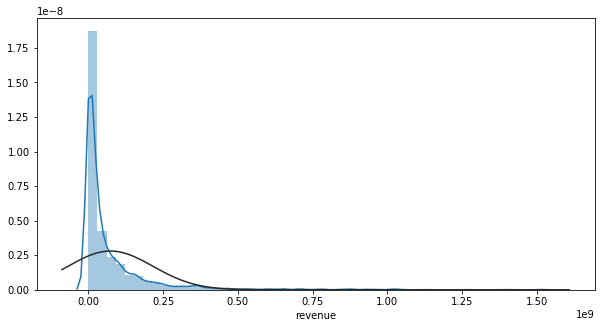

In [26]:
from scipy.stats import norm

plt.subplots(figsize=(10,5))
sns.distplot(train_clean['revenue'], fit=norm)
plt.show()

The model is heavily right-skewed, hence linear models will have a hard time predicting. To correct this we can log-transform the revenue so that it will be transformed into a 'more' looking one.

In [27]:
train_clean['log_revenue'] = np.log1p(train_clean['revenue'])

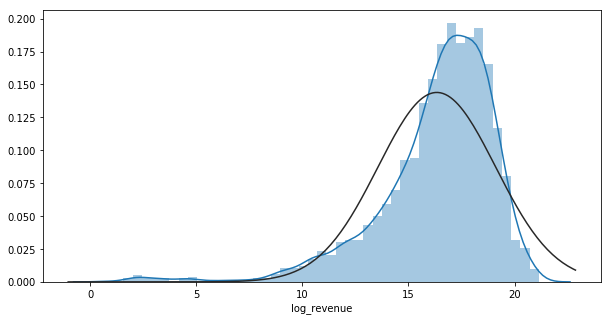

In [28]:
plt.subplots(figsize=(10,5))
sns.distplot(train_clean['log_revenue'], fit=norm)
plt.show()

That will have to do.

### 2.2 Multivariate on revenue

#### 2.2.1 On Continous variables.

## 3. Feature Engineering.

### 3.1. Handle Genres
To handle genres I will first transform it to a number of matrices representing the various genres - one-hot encoded. I've decided upon this method because a movie can be various genres at the same time.

But first - let's get the unique genres.

In [40]:
def get_unique_genre_list(df):
    '''
    gets the original dataframe and return an object containing the unique genres and their ids.
    '''
    # construct the list of genres
    genres_col = df['genres']
    genres_list = []
    for item in genres_col:
        if str(item) == 'nan':
            pass
        else:
            genres_list +=  ast.literal_eval(item)
    
    # construct the lists for both ids and genres
    genre_string_list = []
    genre_id_list = []
    for movie in genres_list:
        genre_string_list.append(movie['name'])
        genre_id_list.append(movie['id'])
    # filter for unique
    unique_ids = []
    unique_genres = []
    unique_id_str = []
    for i in range(0, len(genre_id_list)):
        if genre_id_list[i] not in unique_ids:
            unique_ids.append(genre_id_list[i])
            unique_genres.append(genre_string_list[i])
            unique_id_str.append({'id': genre_id_list[i], 'name': genre_string_list[i]})
            
    return {
        'genre_strings': unique_genres,
        'genre_id': unique_ids,
        'genre_id_str': unique_id_str
        }

In [41]:
genre_list = get_unique_genre_list(train_df)

In [42]:
genre_list['genre_id_str']

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'},
 {'id': 53, 'name': 'Thriller'},
 {'id': 28, 'name': 'Action'},
 {'id': 16, 'name': 'Animation'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 27, 'name': 'Horror'},
 {'id': 99, 'name': 'Documentary'},
 {'id': 10402, 'name': 'Music'},
 {'id': 80, 'name': 'Crime'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 9648, 'name': 'Mystery'},
 {'id': 10769, 'name': 'Foreign'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 10752, 'name': 'War'},
 {'id': 37, 'name': 'Western'},
 {'id': 36, 'name': 'History'},
 {'id': 10770, 'name': 'TV Movie'}]

In [32]:
genre_list['genre_id']

[35,
 18,
 10751,
 10749,
 53,
 28,
 16,
 12,
 27,
 99,
 10402,
 80,
 878,
 9648,
 10769,
 14,
 10752,
 37,
 36,
 10770]

In [37]:
for idx, row in train_df.iterrows():
    print(row)

id                                                                      1
budget                                                           14000000
genres                                     [{'id': 35, 'name': 'Comedy'}]
imdb_id                                                         tt2637294
original_language                                                      en
original_title                                     Hot Tub Time Machine 2
overview                When Lou, who has become the "father of the In...
popularity                                                        6.57539
poster_path                              /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
production_companies    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
production_countries    [{'iso_3166_1': 'US', 'name': 'United States o...
release_date                                                      2/20/15
runtime                                                                93
spoken_languages                 [{'is

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

